## A model to identify potatoes diseases

In [69]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
import os
from tensorflow.keras.models import save_model

In [13]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [14]:
# Lloading the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE 
    
)

print("The total batches in the dataset is", len(dataset))

Found 2152 files belonging to 3 classes.
The total batches in the dataset is 68


In [15]:
# checking the class names
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)


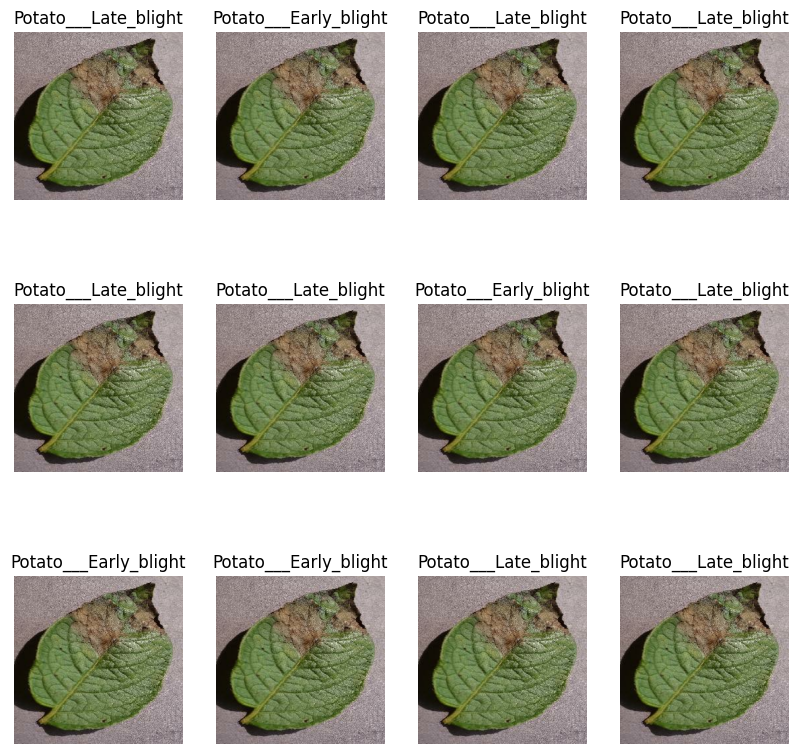

In [16]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    for i in range(12):
        ax= plt.subplot(3,4, i+1)
        plt.imshow(image_batch[0].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [17]:
# Splitting the dataset into train, test and validation
# 80% training
# 10% validation 
# # 10% test

train_size = 0.8
len(dataset) * train_size


54.400000000000006

In [18]:
train_ds = dataset.take(54)
len(train_ds)

54

In [19]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [20]:
val_size = 0.1
len(dataset) * val_size


6.800000000000001

In [21]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [22]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [23]:
def get_dataset_partitions(ds, train_split=0.8, val_split=0.1, test_split = 0.1, shuffle = True, shuffle_size= 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)  #seed is for predictability
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    
    
    return train_ds, val_ds, test_ds

In [24]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [25]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

In [26]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
# preprocessing/scaling the images

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE), # Accepts image input of fixed shape
    layers.Rescaling(1.0/255),
    ])

In [28]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.2, 0.2)
])

In [29]:
input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    layers.Input(shape=input_shape),  # Input layer
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')  # output layer with softmax activation for multi-class classification
    ])

model.build(input_shape = (None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [30]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# compile the model
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [32]:
#  The variable history is used to store the training history returned by model.fit
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.4812 - loss: 0.9487 - val_accuracy: 0.6406 - val_loss: 0.8753
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.6879 - loss: 0.7345 - val_accuracy: 0.7552 - val_loss: 0.5276
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.7829 - loss: 0.5353 - val_accuracy: 0.7812 - val_loss: 0.5408
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.7586 - loss: 0.5551 - val_accuracy: 0.7500 - val_loss: 0.6089
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.8107 - loss: 0.4463 - val_accuracy: 0.9010 - val_loss: 0.4716
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.8829 - loss: 0.3336 - val_accuracy: 0.8385 - val_loss: 0.3851
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8865 - loss: 0.3379 - val_accuracy: 0.8594 - val_loss: 0.3221
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.9085 - loss: 0.2448 - val_accuracy: 0.7760 - va

In [44]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 338ms/step - accuracy: 1.0000 - loss: 0.0094


In [45]:
history

In [46]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [47]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [48]:
history.history['accuracy']

[0.4913194477558136,
 0.7181712985038757,
 0.7829861044883728,
 0.7766203880310059,
 0.8188657164573669,
 0.8802083134651184,
 0.8663194179534912,
 0.9155092835426331,
 0.9045138955116272,
 0.9195601940155029,
 0.9322916865348816,
 0.9415509104728699,
 0.9537037014961243,
 0.9635416865348816,
 0.9565972089767456,
 0.9618055820465088,
 0.9699074029922485,
 0.9629629850387573,
 0.9589120149612427,
 0.9762731194496155,
 0.9589120149612427,
 0.9814814925193787,
 0.9866898059844971,
 0.9733796119689941,
 0.9716435074806213,
 0.9652777910232544,
 0.9768518805503845,
 0.9878472089767456,
 0.9780092835426331,
 0.9855324029922485,
 0.9890046119689941,
 0.9901620149612427,
 0.9606481194496155,
 0.9745370149612427,
 0.9872685074806213,
 0.9809027910232544,
 0.9728009104728699,
 0.9855324029922485,
 0.9866898059844971,
 0.9866898059844971,
 0.9866898059844971,
 0.9762731194496155,
 0.9820601940155029,
 0.984375,
 0.9930555820465088,
 0.9878472089767456,
 0.9913194179534912,
 0.9913194179534912,
 0

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

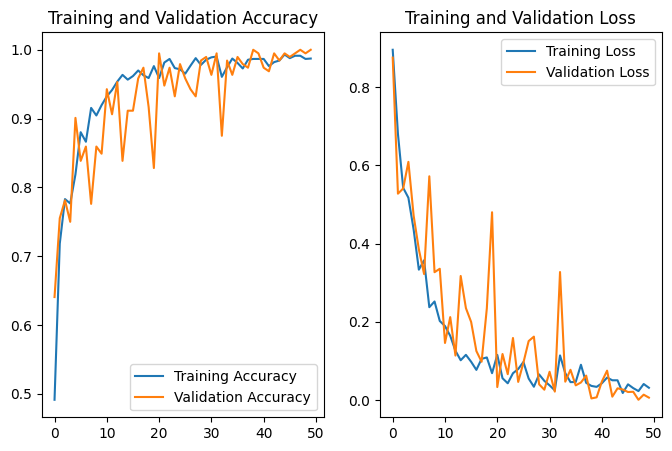

In [50]:
# graph showing the training and validation accuracy
plt.figure(figsize = (8,5))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

# Graph showing the training loss and validation loss
plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')


First image to predict
Actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
Predicted label Potato___Early_blight


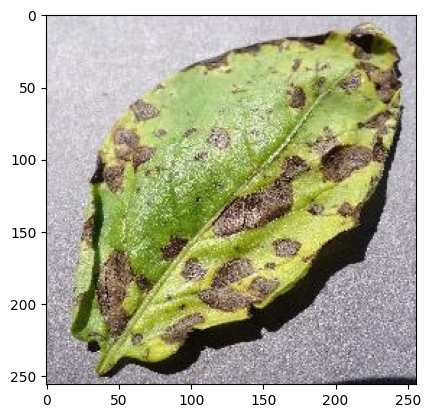

In [55]:
# MAke predictions on the test dataset
import numpy as np

for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()
  
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted label", class_names[np.argmax(batch_prediction[0])])

In [56]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100* (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


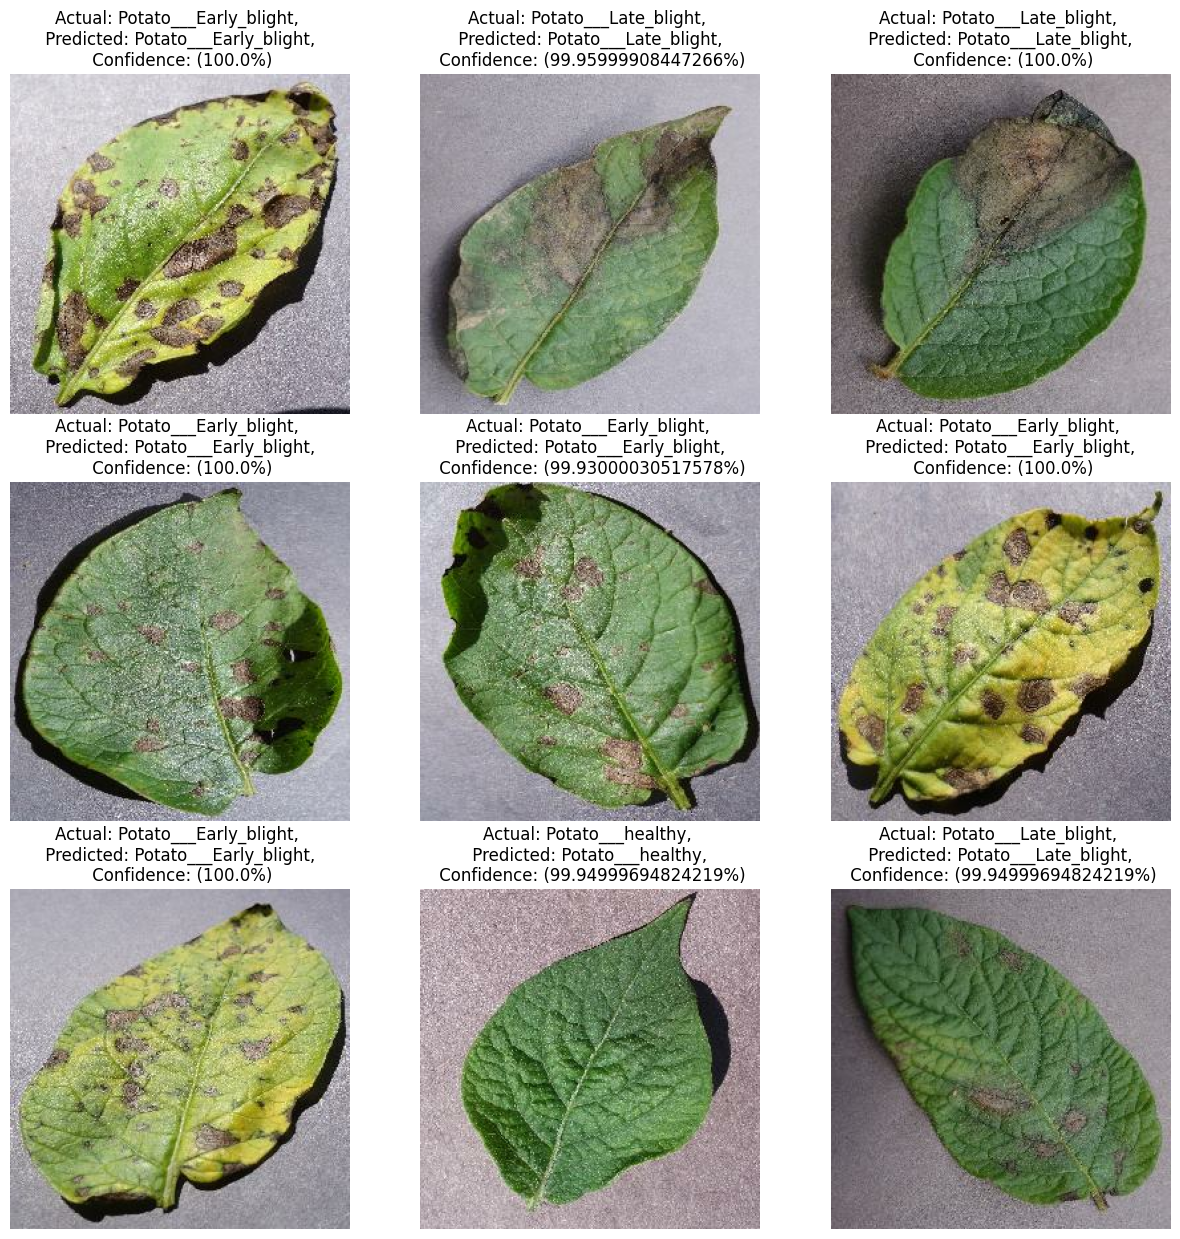

In [67]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # Display the image
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: ({confidence}%)")
        
        plt.axis("off")

In [75]:
import os
# model_version = max([int(i) for i in os.listdir("../models") + [0]]) +1
# model.save(f"../models/{model_version}")

# Create the models directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# Get existing versions
existing_versions = [
    int(folder.replace("v", ""))
    for folder in os.listdir("models")
    if folder.startswith("v") and os.path.isdir(os.path.join("models", folder))
]

# Determine next version
next_version = f"v{max(existing_versions + [0]) + 1}"

# Save model
save_path = os.path.join("models", f"{next_version}.h5")
model.save(save_path)


print(f"✅ Model saved to: {save_path}")



✅ Model saved to: models\v1.h5
